## Tutorial: how to import the data and visualise them

In [87]:
import numpy as np
import networkx as nx
import pandas as pd
import random
from tqdm import tqdm
from hyperparticle.data_handler import ParticleDataset, OneSet

import ot
import graphicle as gcl
from hyperlib.embedding.sarkar import sarkar_embedding

import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch

#helper functions for plots
from hyperparticle.utils.visualisation import plot_geodesic, get_colors, hard_descendants
from hyperparticle.utils.metrics import sqdist, distance_matrix, precision_and_recall, mAP

from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

## The dataset

The dataset is structured as a Pytorch dataset. The two inputs are the path for the data directory and the signal name (this depends on the physics event we are interested in and it is chosen once the data is generated).

The dataset spits each event as dictionary which contains a graphicle object and a hyperbolic coordinates array for each of the algorithm tree (AntiKt, CA and Kt) and for the MC truth.

In [ ]:
dataset = ParticleDataset('../data/jet_tagging/train_sig/')
event = dataset[4]

In [ ]:
event.keys()

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax = ax.flatten()

keys = [k for k in event.keys()]
titles = ['Anti-Kt tree', 'CA tree', 'Kt tree',]
for k in range(1, 6, 2):
    i = k//2
    graph, hyp = event[keys[k]], event[keys[k+1]]
    graph, hyp = event[keys[k]], event[keys[k+1]]
    
    G = nx.Graph()
    G.add_edges_from(graph.edges)
    nodes = np.array(G.nodes())
    mapping = {nodes[i]: i for i in range(len(nodes))}
    G = nx.relabel_nodes(G, mapping)
    nodes = np.array(G.nodes())
    for edge in G.edges:
        start = np.where(nodes == edge[0])[0][0]
        end = np.where(nodes == edge[1])[0][0]
        x0,y0 = hyp[start]
        x1,y1 = hyp[end]
        #ax.plot([x0,x1],[y0,y1],alpha=0.1,color='black')
        plot_geodesic(hyp[start],hyp[end],ax[i])

    ax[i].scatter(hyp[:,0], hyp[:,1], c='orange', s=150, alpha=0.6)
    
    disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
    ax[i].add_patch(disk)
    ax[i].set_xlim(-1.05,1.05)
    ax[i].set_ylim(-1.05,1.05)
    ax[i].set_title(titles[i])

plt.show()
#plt.savefig('example.png')

## Testing clustering on new data

In [82]:
from showerpipe.generator import PythiaGenerator
from showerpipe.lhe import split
from hyperparticle.tree import FamilyTree
from hyperparticle.utils.transform import center

def embed(jet):
    G = nx.Graph()
    G.add_edges_from(jet.edges)
    nodes = np.array(G.nodes())
    mapping = {nodes[i]: i for i in range(len(nodes))}
    G = nx.relabel_nodes(G, mapping)

    embed = sarkar_embedding(tree=G, root=mapping[-1], tau=0.6, weighted=False)
    hyp = np.array(list(map(float, embed))).reshape(-1, 2) 
    return hyp

In [83]:
pythia_path = "../hyperparticle/data_generator/pythia-settings.cmnd"
lhe_file = "../data/single_qcd/jz.lhe.gz"
data = next(split(lhe_file, 100))
gen = PythiaGenerator(pythia_path, data)

In [84]:
graph = gcl.Graphicle.from_event(next(gen))
tree = FamilyTree(graph)
jet = tree.history(R=1., p=-1, recluster=False)
hyp = embed(jet)

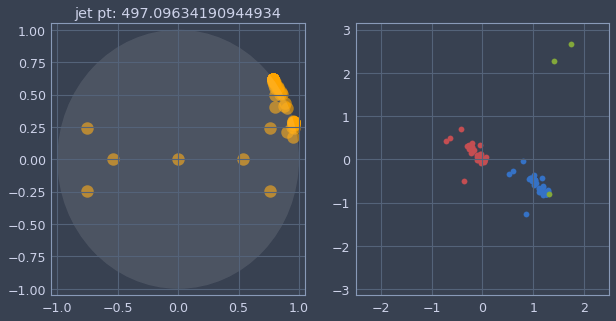

In [85]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax = ax.flatten()

ax[0].scatter(hyp[:,0], hyp[:,1], c='orange', s=150, alpha=0.6)
disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
ax[0].add_patch(disk)
ax[0].set_xlim(-1.05,1.05)
ax[0].set_ylim(-1.05,1.05)
ax[0].set_title(f'jet pt: {jet.pmu.pt[0]}')

ax[1].scatter(jet.pmu.eta, jet.pmu.phi)
ax[1].scatter(graph.pmu.eta[graph.hard_mask['outgoing']],
           graph.pmu.phi[graph.hard_mask['outgoing']])
jet2 = center(jet)
ax[1].scatter(jet2.pmu.eta, jet2.pmu.phi)

ax[1].set_xlim(-2.5,2.5)
ax[1].set_ylim(-np.pi, np.pi)
plt.show()